In [1]:
# Import Statements
import numpy as np
import pandas as pd
from sklearn.metrics import *
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
#  Import data from the UCI database
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data'
data = pd.read_csv(url, header = None)

#  These were grabbed from the above website where they define the variables
data.columns = ['Class', 'Age', 'Sex', 'Steroid', 'Antiviral', 'Fatigue', 'Malaise', 'Anorexia', 'Liver Big', 
               'Liver Firm', 'Spleen Palpable', 'Spiders', 'Ascites', 'Varices', 'Bilirubin', 'Alk', 'Sgot',
               'Albumin', 'Protime', 'Histology']

#  This is just to help me seperate the column names
categorical_data = ['Steroid', 'Antiviral', 'Fatigue', 'Malaise', 'Anorexia', 'Liver Big', 
               'Liver Firm', 'Spleen Palpable', 'Spiders', 'Ascites', 'Varices', 'Histology']

non_categorical_data = ['Age', 'Bilirubin', 'Alk', 'Sgot', 'Albumin', 'Protime']

In [3]:
#  We need to clean the data and see what we need to fix
data = data.replace(to_replace="?", value=np.nan).apply(pd.to_numeric, errors = "coerse")
data.apply(lambda l: np.isnan(l).sum())

Class               0
Age                 0
Sex                 0
Steroid             1
Antiviral           0
Fatigue             1
Malaise             1
Anorexia            1
Liver Big          10
Liver Firm         11
Spleen Palpable     5
Spiders             5
Ascites             5
Varices             5
Bilirubin           6
Alk                29
Sgot                4
Albumin            16
Protime            67
Histology           0
dtype: int64

In [4]:
#  I am going to remove the rows where there are not a log of missing variables.
data = data.loc[~np.isnan(data.Steroid),:]
data = data.loc[~np.isnan(data.Fatigue),:]
data = data.loc[~np.isnan(data.Spiders),:]
data = data.loc[~np.isnan(data["Liver Big"]),:]
data = data.loc[~np.isnan(data["Liver Firm"]),:]

# This is going to be the replacement of nan's with the median
data.Bilirubin.fillna(value = np.nanmedian(data.Bilirubin), inplace=True)
data.Alk.fillna(value = np.nanmedian(data.Alk), inplace=True)
data.Sgot.fillna(value = np.nanmedian(data.Sgot), inplace=True)
data.Albumin.fillna(value = np.nanmedian(data.Albumin), inplace=True)

# I need to remove protime as it has almost half missing values
data.drop(columns = "Protime", inplace = True)

#  We need to also remove it from our column list
non_categorical_data.remove("Protime")
data[non_categorical_data] = data[non_categorical_data].apply(lambda l: (l - np.mean(l)) / np.std(l))

In [5]:
target = 'Class'

feature_train, feature_test, target_train, target_test = train_test_split(
    data[data.columns.difference(list(target))], 
    data[target], 
    random_state=0,
    test_size = 0.7)  
#  train_target_split randomly splits dataframes into four groups

In [6]:
#  SVC Model because I think it is very robust, although run time can be pretty long for big sets
svc_mod = SVC(probability=True)
svc_mod.fit(feature_train, target_train)
svc_pred = svc_mod.predict(feature_test)
prob = svc_mod.predict_proba(feature_test)
prob_pos = prob[:,1]

In [7]:
#  Code to create the confusion matrix and outputs
CM = confusion_matrix(target_test, svc_pred)
print ("\n\nConfusion matrix:\n", CM)
tn, fp, fn, tp = CM.ravel()
print ("\nTP, TN, FP, FN:", tp, ",", tn, ",", fp, ",", fn)
AR = accuracy_score(target_test, svc_pred)
print ("\nAccuracy rate:", AR)
ER = 1.0 - AR
print ("\nError rate:", np.round(ER,2))
P = precision_score(target_test, svc_pred)
print ("\nPrecision:", np.round(P, 2))
R = recall_score(target_test, svc_pred)
print ("\nRecall:", np.round(R, 2))
F1 = f1_score(target_test, svc_pred)
print ("\nF1 score:", np.round(F1, 2))



Confusion matrix:
 [[11  4]
 [ 1 84]]

TP, TN, FP, FN: 84 , 11 , 4 , 1

Accuracy rate: 0.95

Error rate: 0.05

Precision: 0.92

Recall: 0.73

F1 score: 0.81


In [8]:
#  The roc_curve looks for 0's and 1's, not 1's and 2's
target_test_binary = target_test.copy()
target_test_binary.replace(1, 0, inplace=True)
target_test_binary.replace(2, 1, inplace=True)


TP rates: [0.01 0.78 0.78 0.91 0.91 0.99 0.99 1.   1.  ]

FP rates: [0.   0.   0.07 0.07 0.13 0.13 0.27 0.27 1.  ]

Probability thresholds: [0.98 0.84 0.83 0.72 0.71 0.52 0.48 0.45 0.03]

AUC score (using auc function): 0.98




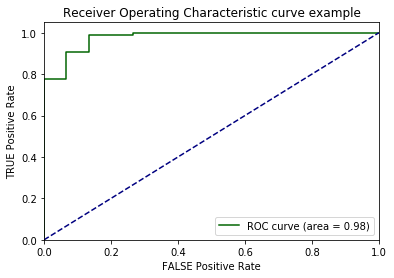

In [9]:
#  Settings for plot and ROC Curve
LW = 1.5
LL = "lower right"
LC = "darkgreen"

fpr, tpr, th = roc_curve(np.array(target_test_binary), np.array(prob_pos))
AUC = auc(fpr, tpr)
print ("\nTP rates:", np.round(tpr, 2))
print ("\nFP rates:", np.round(fpr, 2))
print ("\nProbability thresholds:", np.round(th, 2))
print ("\nAUC score (using auc function):", np.round(AUC, 2))
print("\n")
plt.figure()
plt.title("Receiver Operating Characteristic curve example")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FALSE Positive Rate")
plt.ylabel("TRUE Positive Rate")
plt.plot(fpr, tpr, color=LC,lw=LW, label="ROC curve (area = %0.2f)" % AUC)
plt.plot([0, 1], [0, 1], color="navy", lw=LW, linestyle='--')
plt.legend(loc=LL)
plt.show()